In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

from xgboost import XGBClassifier

import shap
import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")

In [29]:
df = pd.read_csv("data/merged_features.csv")
df["Date"] = pd.to_datetime(df["Date"])

features = ["Return","RollingVol","RSI","SMA_20","SMA_50","Volume_Z","VIX"]
print(df.head())

        Date Ticker      Close       High        Low       Open     Volume  \
0 2015-03-16   AAPL  27.809700  27.809700  27.346763  27.571554  143497200   
1 2015-03-16   AMZN  18.667500  18.697001  18.336000  18.518999   47082000   
2 2015-03-16    DAL  40.501942  40.791494  40.326456  40.493169    8517000   
3 2015-03-16  GOOGL  27.889645  27.994421  27.377178  27.655757   36856000   
4 2015-03-16    JPM  46.242439  46.294775  45.793848  45.980761   15182900   

     Return  RollingVol        RSI     SMA_20     SMA_50  Volume_Z    VIX  \
0  0.011004    0.012886  51.177508  28.424203  26.586998 -1.322438  15.61   
1  0.007475    0.014070  53.483548  18.935100  17.347630 -0.584754  15.61   
2  0.014506    0.018240  52.787405  39.891689  40.751535 -1.195312  15.61   
3  0.015624    0.012757  54.684637  27.735530  26.665128 -0.254974  15.61   
4  0.013935    0.013635  59.083914  45.507863  44.026835 -0.167447  15.61   

   Direction  VolSpike  
0          1         0  
1          1      

In [30]:
# Create Target / Ticker
def build_nextday_target(df, base_target_col):
    df = df.sort_values(["Ticker","Date"]).copy()
    next_col = base_target_col + "_next"
    df[next_col] = df.groupby("Ticker")[base_target_col].shift(-1)
    df = df.dropna(subset=features + [next_col])
    return df, next_col

# 80 / 20 Time Split w/ Tickers
def split_by_ticker(df, target_col_next, train_size=0.8):
    tickers = df["Ticker"].unique()
    train_list, test_list = [], []

    for t in tickers:
        temp = df[df["Ticker"] == t]
        cut = int(len(temp) * train_size)
        train_list.append(temp.iloc[:cut])
        test_list.append(temp.iloc[cut:])

    train = pd.concat(train_list)
    test = pd.concat(test_list)

    X_train = train[features]
    X_test = test[features]
    y_train = train[target_col_next]
    y_test = test[target_col_next]

    return train, test, X_train, X_test, y_train, y_test

In [31]:
# Future Direction
df_dir, target_dir_next = build_nextday_target(df, "Direction")
train_dir, test_dir, X_train_dir, X_test_dir, y_train_dir, y_test_dir = split_by_ticker(df_dir, target_dir_next)

# Predicted VolSpike
df_vol, target_vol_next = build_nextday_target(df, "VolSpike")
train_vol, test_vol, X_train_vol, X_test_vol, y_train_vol, y_test_vol = split_by_ticker(df_vol, target_vol_next)

print("Direction target column:", target_dir_next)
print("VolSpike target column:", target_vol_next)

Direction target column: Direction_next
VolSpike target column: VolSpike_next


In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Volatility models (consistent eval output)
lr_vol = LogisticRegression(max_iter=1000)
lr_vol.fit(X_train_vol, y_train_vol)
lr_preds = lr_vol.predict(X_test_vol)
lr_probs = lr_vol.predict_proba(X_test_vol)[:,1]

_ = eval_model("VolSpike Logistic Regression", y_test_vol, lr_preds, lr_probs)

rf_vol = RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42)
rf_vol.fit(X_train_vol, y_train_vol)
rf_preds = rf_vol.predict(X_test_vol)
rf_probs = rf_vol.predict_proba(X_test_vol)[:,1]

_ = eval_model("VolSpike Random Forest", y_test_vol, rf_preds, rf_probs)



VolSpike Logistic Regression
Accuracy: 0.8856
F1 Score: 0.2488
ROC AUC: 0.8219

VolSpike Random Forest
Accuracy: 0.8678
F1 Score: 0.5991
ROC AUC: 0.9184


In [33]:
scaler_dir = StandardScaler()
X_train_dir_scaled = scaler_dir.fit_transform(X_train_dir)
X_test_dir_scaled = scaler_dir.transform(X_test_dir)

scaler_vol = StandardScaler()
X_train_vol_scaled = scaler_vol.fit_transform(X_train_vol)
X_test_vol_scaled = scaler_vol.transform(X_test_vol)

def train_xgb(X_train, y_train):
    model = XGBClassifier(
        n_estimators=500,
        learning_rate=0.03,
        max_depth=7,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42
    )
    model.fit(X_train, y_train)
    return model

xgb_dir = train_xgb(X_train_dir, y_train_dir)
xgb_vol = train_xgb(X_train_vol, y_train_vol)

proba_dir = xgb_dir.predict_proba(X_test_dir)[:,1]
pred_dir = (proba_dir > 0.5).astype(int)

proba_vol = xgb_vol.predict_proba(X_test_vol)[:,1]
pred_vol = (proba_vol > 0.5).astype(int)

def eval_model(name, y_true, preds, probs):
    print(f"\n{name}")
    print("Accuracy:", round(accuracy_score(y_true, preds),4))
    print("F1 Score:", round(f1_score(y_true, preds),4))
    print("ROC AUC:", round(roc_auc_score(y_true, probs),4))

eval_model("XGBoost Direction", y_test_dir, pred_dir, proba_dir)
eval_model("XGBoost VolSpike", y_test_vol, pred_vol, proba_vol)


XGBoost Direction
Accuracy: 0.5134
F1 Score: 0.5592
ROC AUC: 0.5073

XGBoost VolSpike
Accuracy: 0.8583
F1 Score: 0.584
ROC AUC: 0.9144


In [34]:
# Added: readable probability-to-decision examples

def prob_to_text(p):
    decision = "UP" if p >= 0.5 else "DOWN"
    return f"P(up)={p:.2f} -> {decision}"

dir_samples = [prob_to_text(p) for p in proba_dir[:5]]
vol_samples = [f"P(spike)={p:.2f}" for p in proba_vol[:5]]

print("Sample direction outputs:")
for s in dir_samples:
    print(" -", s)

print("\nSample vol-spike probs:")
for s in vol_samples:
    print(" -", s)


Sample direction outputs:
 - P(up)=0.53 -> UP
 - P(up)=0.44 -> DOWN
 - P(up)=0.43 -> DOWN
 - P(up)=0.55 -> UP
 - P(up)=0.53 -> UP

Sample vol-spike probs:
 - P(spike)=0.51
 - P(spike)=0.41
 - P(spike)=0.43
 - P(spike)=0.02
 - P(spike)=0.01


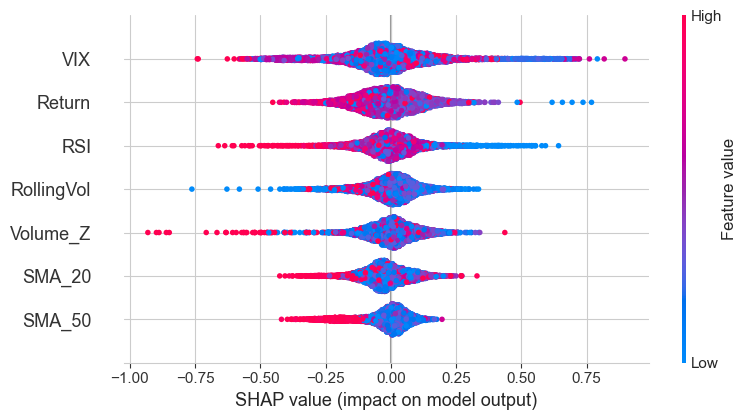

In [35]:
# Test for SHAP Explanations
# Direction model
explainer_dir = shap.TreeExplainer(xgb_dir)
shap_values_dir = explainer_dir.shap_values(X_test_dir)

shap.summary_plot(shap_values_dir, X_test_dir, feature_names=features)

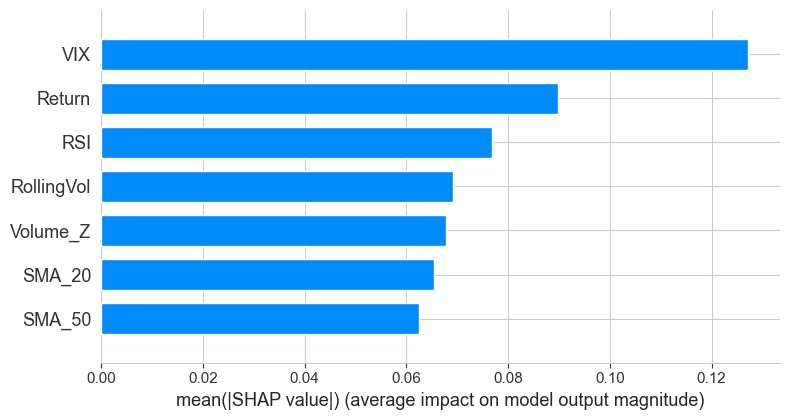

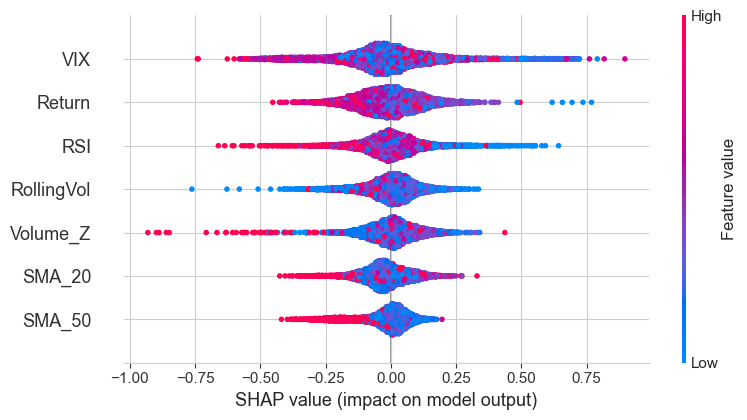

In [36]:
# Absolute SHAP
shap.summary_plot(shap_values_dir, X_test_dir, feature_names=features, plot_type="bar") # Global Importance

# Beeswarm for Local / Global Dis
shap.summary_plot(shap_values_dir, X_test_dir, feature_names=features)

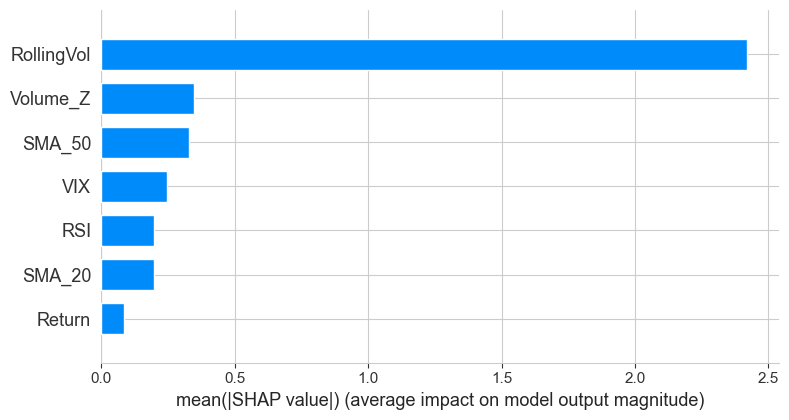

In [37]:
explainer_vol = shap.TreeExplainer(xgb_vol)
shap_values_vol = explainer_vol.shap_values(X_test_vol)

shap.summary_plot(shap_values_vol, X_test_vol, feature_names=features, plot_type="bar", show=True)

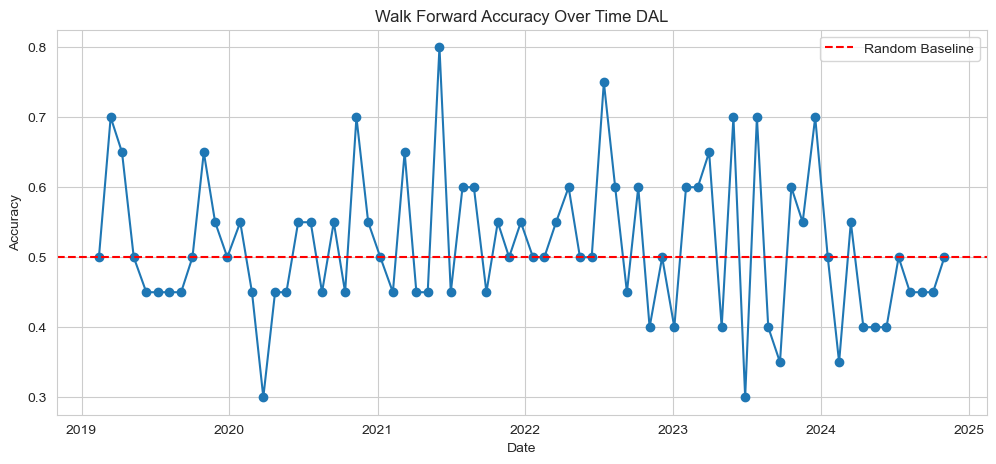

In [38]:
ticker = "DAL"
df_DAL, _ = build_nextday_target(df[df["Ticker"] == ticker], "Direction")

df_DAL = df_DAL.sort_values("Date").reset_index(drop=True)

X_all = df_DAL[features].values
y_all = df_DAL["Direction_next"].values

window_train = int(len(df_DAL) * 0.4)  # Train Size 40%
step_size = 20                          # Evaluate Every 20 Days

acc_list = []
dates_list = []

for end in range(window_train, len(df_DAL)-step_size, step_size):
    X_train_wf = X_all[:end]
    y_train_wf = y_all[:end]
    X_test_wf = X_all[end:end+step_size]
    y_test_wf = y_all[end:end+step_size]
    
    model_wf = train_xgb(X_train_wf, y_train_wf)
    preds_wf = model_wf.predict(X_test_wf)
    
    acc_list.append(accuracy_score(y_test_wf, preds_wf))
    dates_list.append(df_DAL["Date"].iloc[end])

wf_results = pd.DataFrame({"Date": dates_list, "Accuracy": acc_list})

plt.figure(figsize=(12,5))
plt.plot(wf_results["Date"], wf_results["Accuracy"], marker="o")
plt.axhline(0.5, color="red", linestyle="--", label="Random Baseline")
plt.title(f"Walk Forward Accuracy Over Time {ticker}")
plt.xlabel("Date")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

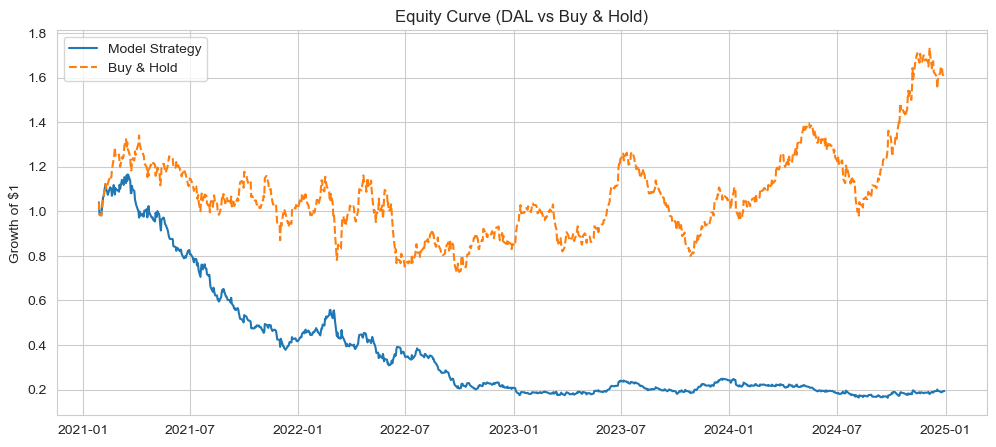

Model strategy: total=-80.60%  CAGR=-34.18%  maxDD=-85.99%  Sharpe=-0.95
Buy & Hold: total=60.11%  CAGR=12.76%  maxDD=-45.75%  Sharpe=0.51


In [39]:
# Walk Forward Model
# Simulate Full Series
# Refit First 60% 
# Walk Forward Predicting

split = int(len(df_DAL) * 0.6)
X_train_bt = X_all[:split]
y_train_bt = y_all[:split]
X_test_bt = X_all[split:]
y_test_bt = y_all[split:]

model_bt = train_xgb(X_train_bt, y_train_bt)
proba_bt = model_bt.predict_proba(X_test_bt)[:,1]
pred_bt = (proba_bt > 0.5).astype(int)

# Future Returns
returns = pd.Series(df_DAL["Return"].iloc[split:].values, index=df_DAL["Date"].iloc[split:])

# Strat: Long if pred=1 Short if pred=0
positions = pd.Series(np.where(pred_bt == 1, 1, -1), index=returns.index)
strategy_returns = positions * returns

equity_strategy = (1 + strategy_returns).cumprod()
equity_buyhold = (1 + returns).cumprod()

dates_bt = returns.index

plt.figure(figsize=(12,5))
plt.plot(dates_bt, equity_strategy, label="Model Strategy")
plt.plot(dates_bt, equity_buyhold, label="Buy & Hold", linestyle="--")
plt.title(f"Equity Curve (DAL vs Buy & Hold)")
plt.ylabel("Growth of $1")
plt.legend()
plt.show()

# Added: backtest summary stats
def backtest_stats(eq, rets, label, periods_per_year=252):
    total_return = eq.iloc[-1] - 1
    years = (eq.index[-1] - eq.index[0]).days / 365.25
    cagr = (eq.iloc[-1])**(1/years) - 1 if years > 0 else np.nan
    max_dd = (eq / eq.cummax() - 1).min()
    vol = rets.std() * (periods_per_year ** 0.5)
    sharpe = (rets.mean() * periods_per_year) / vol if vol != 0 else np.nan
    print(f"{label}: total={total_return:.2%}  CAGR={cagr:.2%}  maxDD={max_dd:.2%}  Sharpe={sharpe:.2f}")

backtest_stats(equity_strategy, strategy_returns, "Model strategy")
backtest_stats(equity_buyhold, returns, "Buy & Hold")


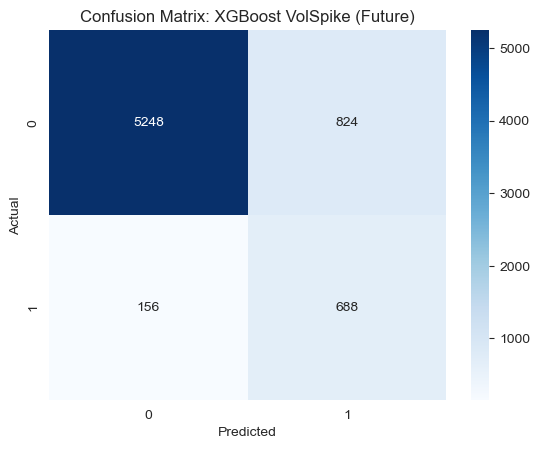


VolSpike XGBoost
Accuracy: 0.8583
F1 Score: 0.584
ROC AUC: 0.9144


In [40]:
cm_vol = confusion_matrix(y_test_vol, pred_vol)
sns.heatmap(cm_vol, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix: XGBoost VolSpike (Future)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Evaluation report (consistent format)
_ = eval_model("VolSpike XGBoost", y_test_vol, pred_vol, proba_vol)
